In [1]:
#Importing Required modules
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdmolops
from rdkit.Chem import RDConfig
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold

from collections import defaultdict
from itertools import product
import igraph
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import re
IPythonConsole.ipython_useSVG = True

In [2]:
#creting a function to...
def gengraph(mols,fpgen , threshold=0.7):
    fps = [fpgen.GetFingerprint(m) for m in mols]
    num_v = len(mols)
    graph = igraph.Graph()
    graph.add_vertices(num_v)
    for i in range(num_v):
        for j in range(i):
            if DataStructs.TanimotoSimilarity(fps[i], fps[j]) >= threshold:
                graph.add_edge(i, j)
    return graph

In [3]:
#Creating a function that joins two molecules together
def makebond(target, chain):
    newmol = Chem.RWMol(rdmolops.CombineMols(target, chain))
    atoms = newmol.GetAtoms()
    mapper = defaultdict(list)
    for idx, atm in enumerate(atoms):
        atom_map_num = atm.GetAtomMapNum()
        mapper[atom_map_num].append(idx)
    for idx, a_list in mapper.items():
        if len(a_list) == 2:
            atm1, atm2 = a_list
            rm_atoms = [newmol.GetAtomWithIdx(atm1),newmol.GetAtomWithIdx(atm2)]
            nbr1 = [x.GetOtherAtom(newmol.GetAtomWithIdx(atm1)) for x in newmol.GetAtomWithIdx(atm1).GetBonds()][0]
            nbr1.SetAtomMapNum(idx)
            nbr2 = [x.GetOtherAtom(newmol.GetAtomWithIdx(atm2)) for x in newmol.GetAtomWithIdx(atm2).GetBonds()][0]
            nbr2.SetAtomMapNum(idx)
    newmol.AddBond(nbr1.GetIdx(), nbr2.GetIdx(), order=Chem.rdchem.BondType.SINGLE)
    nbr1.SetAtomMapNum(0)
    nbr2.SetAtomMapNum(0)
    newmol.RemoveAtom(rm_atoms[0].GetIdx())
    newmol.RemoveAtom(rm_atoms[1].GetIdx())
    newmol = newmol.GetMol()
    return newmol

In [4]:
#Creating a function that enumerates molcules
def enumeratemol(core,rg, maxmol=10000):
    dataset = rg.GetRGroupsAsColumns()
    labels = list(dataset.keys())
    pat = re.compile("R\d+")
    labels = [label for label in labels if pat.match(label)]
    rgs = np.asarray([dataset[label] for label in labels])
    i, j = rgs.shape
    combs = [k for k in product(range(j), repeat=i)]
    res = []
    for i in combs:
        mol = core
        for idx,j in enumerate(i):
            mol = makebond(mol, rgs[idx][j])
        AllChem.Compute2DCoords(mol)
        mol = Chem.RemoveHs(mol)
        res.append(mol)
    return res

In [5]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(2)

In [6]:
mols = [m for m in Chem.SDMolSupplier('core3.sdf')]
for mol in mols:
    AllChem.Compute2DCoords(mol)
fps = [fpgen.GetFingerprint(m) for m in mols]


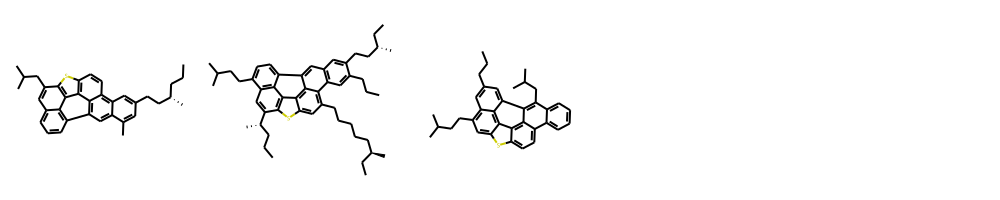

In [7]:
Draw.MolsToGridImage(mols, molsPerRow=5)

In [8]:
graph = gengraph(mols, fpgen, 0.4)
blks=graph.blocks()
simmols_idx = sorted(list(blks), key=lambda x: len(x), reverse=True)
simmols_idx

[[0, 2]]

In [9]:
simmols = [mols[i] for i in simmols_idx[0]]
scaff = [MurckoScaffold.GetScaffoldForMol(m) for m in simmols]
scaff

In [10]:
mcs1 = rdFMCS.FindMCS(scaff, threshold=0.7)
mcs2 = rdFMCS.FindMCS(scaff, threshold=0.7, 
                      completeRingsOnly=True,
                      matchValences=True,
                      bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                      atomCompare=rdFMCS.AtomCompare.CompareElements,
                      )
mcs3 = rdFMCS.FindMCS(scaff, threshold=0.7,
                      ringMatchesRingOnly=True,
                      completeRingsOnly=True,
                      atomCompare=rdFMCS.AtomCompare.CompareAny)

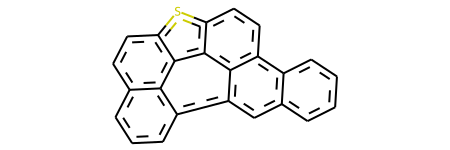

In [11]:
Chem.MolFromSmarts(mcs1.smartsString)

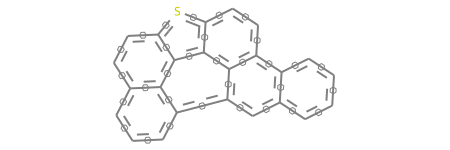

In [12]:
Chem.MolFromSmarts(mcs2.smartsString)

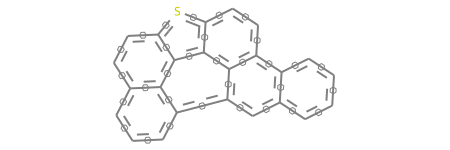

In [13]:
Chem.MolFromSmarts(mcs3.smartsString)

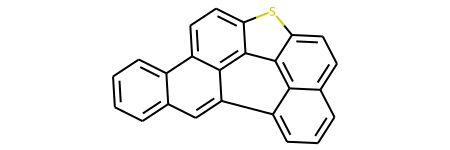

In [14]:
mols_has_core = []
core = Chem.MolFromSmarts(mcs2.smartsString)
for mol in mols:
    if mol.HasSubstructMatch(core):
        AllChem.Compute2DCoords(mol)
        mols_has_core.append(mol)
def getMCSSmiles(mol, mcs):
    mcsp = Chem.MolFromSmarts(mcs.smartsString)
    match = mol.GetSubstructMatch(mcsp)
    smi = Chem.MolFragmentToSmiles(mol, atomsToUse=match)
    return smi
mcs_smi = getMCSSmiles(mols_has_core[0], mcs1)
core = Chem.MolFromSmiles(mcs_smi)
core

In [15]:
rgp = rdRGroupDecomposition.RGroupDecompositionParameters()
rgp.removeHydrogensPostMatch = True
rgp.alignment =True
rgp.removeAllHydrogenRGroups=True
rg = rdRGroupDecomposition.RGroupDecomposition(core, rgp)
for mol in mols_has_core:
    rg.Add(mol)
rg

In [16]:
rg.Process()

True

In [17]:
frame = pd.DataFrame(rg.GetRGroupsAsColumns())
frame["Smiles"] = [Chem.MolToSmiles(mol) for mol in mols_has_core]
PandasTools.AddMoleculeColumnToFrame(frame)

ROMol  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   

                                              Smiles  \
0  CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc...   
1  CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4...   
2  CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6ccccc6c(CC(C)C)c...   

                                                Core  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   

                                                  R1  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   

                                                  R2  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...
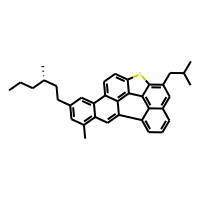
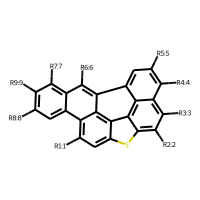
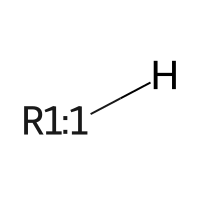
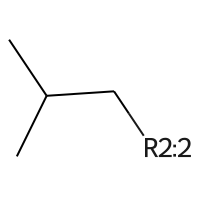
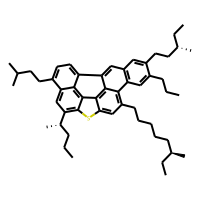
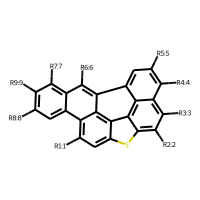
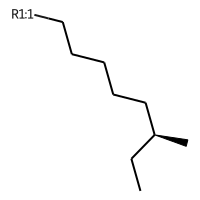
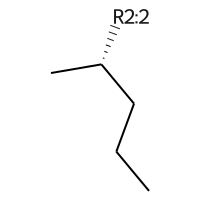
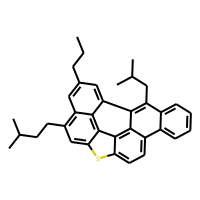
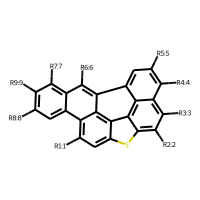
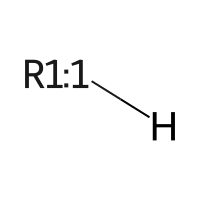
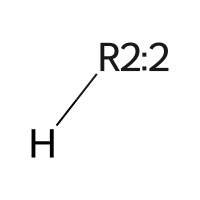

In [18]:
frame = frame[["ROMol", "Smiles", "Core", "R1", "R2"]]
frame['Core']=frame['Core'].apply(Chem.RemoveHs)
frame.head()

In [19]:
dataset = rg.GetRGroupsAsColumns()
core =  Chem.RemoveHs(dataset["Core"][0])

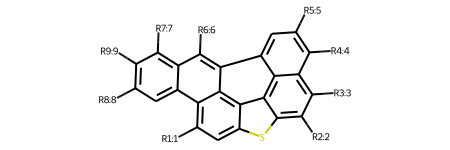

In [20]:
core

In [21]:
res = enumeratemol(core,rg)

C:\Users\Kakashi\anaconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


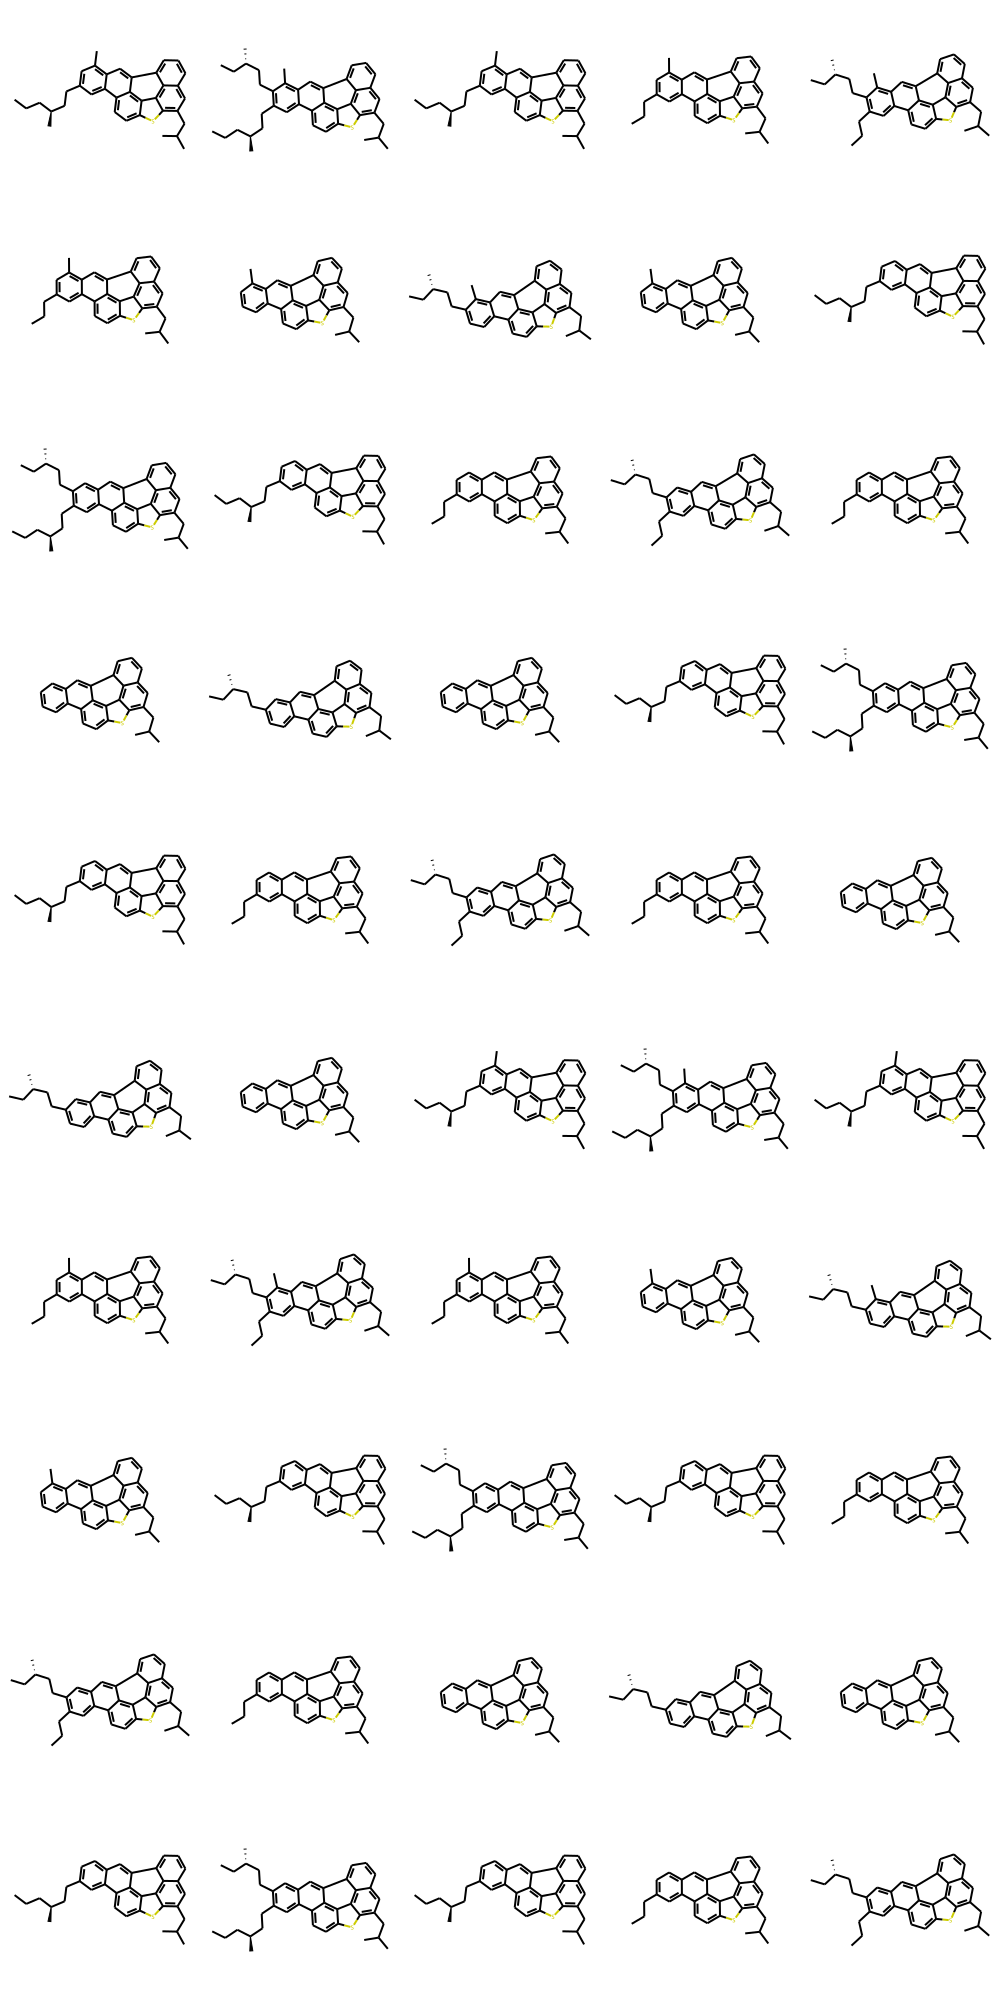

In [22]:
Draw.MolsToGridImage(res[:200],molsPerRow=5)

In [23]:
print(len(res),'molecules generated')

19683 molecules generated


In [24]:
print(res)

[<rdkit.Chem.rdchem.Mol object at 0x0000014869283AC0>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBFA0>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBF40>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBDC0>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBE80>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBE20>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBD60>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBD00>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBC40>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBCA0>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBBE0>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBB80>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBEE0>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CB9A0>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBA60>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CBB20>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CB940>, <rdkit.Chem.rdchem.Mol object at 0x00000148692CB820>, <rdkit.Chem.rdchem.Mol obje

In [25]:
listsmiles=[]
for m in res:
    print(Chem.MolToSmiles(m))
    listsmiles.append(Chem.MolToSmiles(m))
len(listsmiles)

CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc3c4cccc5cc(CC(C)C)c6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc3c4cccc5cc(CC(C)C)c6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
Cc1cccc2c1cc1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CC[C@H](C)CCc1ccc2c(cc3c4cccc5cc(CC(C)C)c6sc7ccc2c3c7c6c54)c1C
Cc1cccc2c1cc1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)Cc1cc2cccc3c4cc5ccccc5c5ccc6sc1c(c23)c6c54
CC[C@H](C)CCc1ccc2c(c1)cc

CCCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)Cc1cc2cccc3c4c(CC(C)C)c5ccccc5c5ccc6sc1c(c23)c6c54
CC[C@H](C)CCc1ccc2c(c1)c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CC(C)Cc1cc2cccc3c4c(CC(C)C)c5ccccc5c5ccc6sc1c(c23)c6c54
CCCc1cc2cc(CC(C)C)c3sc4ccc5c6cc(CC[C@@H](C)CCC)cc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2cc(CC(C)C)c3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2cc(CC(C)C)c3sc4ccc5c6cc(CC[C@@H](C)CCC)cc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc(C)c2cc3c4cc(CCC)cc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2cc(CC(C)C)c3sc4ccc5c6cc(CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c56
CCCc1cc(C)c2cc3c4cc(CCC)cc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2cc(CC(C)C)c3sc4ccc5c6cccc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2cc(CC(C)C)c3sc4ccc5c6ccc(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2cc(CC(C)C)c3sc4ccc5c6cccc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2cc(CC(C)C)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c56
CC

CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CC[C@H](C)CCc1ccc2c(c1)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CC[C@H](C)CCc1ccc2c(c1)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6

CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CC[C@H](C)CCc1ccc2c(c1)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CC[C@H](C)CCc1ccc2c(c1)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c5

CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4cc5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4cc5cc(CC[C@@H](C)CC)ccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4cc5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)CCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(c(C)c1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(c(C)c1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C

CCCc1cc2c(cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCCc1cc(C)c2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)c1cc2cccc3c4cc5c(C)cccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2cccc3c4cc5c(C)c(CC[C@@H](C)CC)ccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2cccc3c4cc5c(C)cccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)c1cc2cccc3c4cc5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2cccc3c4cc5cc(CC[C@@H](C)CC)ccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2cccc3c4cc5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C

CCCc1cc2c3c(CC(C)C)c4c(C)cc(CC[C@@H](C)CCC)cc4c4ccc5sc6c([C@@H](C)CCC)cc(c1CCC(C)C)c2c6c5c43
CCCc1cc(C)c2c(CC(C)C)c3c4cc(CCC)c(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(c(C)c1CC[C@@H](C)CC)c(CC(C)C)c1c3cc(CCC)c(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCCc1cc(C)c2c(CC(C)C)c3c4cc(CCC)c(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c3c(CC(C)C)c4c(C)cccc4c4ccc5sc6c([C@@H](C)CCC)cc(c1CCC(C)C)c2c6c5c43
CCCc1cc2c3c(CC(C)C)c4c(C)c(CC[C@@H](C)CC)ccc4c4ccc5sc6c([C@@H](C)CCC)cc(c1CCC(C)C)c2c6c5c43
CCCc1cc2c3c(CC(C)C)c4c(C)cccc4c4ccc5sc6c([C@@H](C)CCC)cc(c1CCC(C)C)c2c6c5c43
CCCc1cc2c3c(CC(C)C)c4ccc(CC[C@@H](C)CCC)cc4c4ccc5sc6c([C@@H](C)CCC)cc(c1CCC(C)C)c2c6c5c43
CCCc1cc2c3c(CC(C)C)c4cc(CC[C@@H](C)CC)c(CC[C@@H](C)CCC)cc4c4ccc5sc6c([C@@H](C)CCC)cc(c1CCC(C)C)c2c6c5c43
CCCc1cc2c3c(CC(C)C)c4ccc(CC[C@@H](C)CCC)cc4c4ccc5sc6c([C@@H](C)CCC)cc(c1CCC(C)C)c2c6c5c43
CCCc1ccc2c(CC(C)C)c3c4cc(CCC)c(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)c(C

CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6ccccc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6ccc(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6ccccc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c56
CCCc1ccc2cc3c4cc(CCC)cc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c56
CCCc1ccc2cc3c4cc(CCC)cc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6ccccc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6ccc(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6ccccc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC

CCCc1ccc2c(CC(C)C)c3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)c1c(CCC(C)C)c2cccc3c4c(CC(C)C)c5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1c(CCC(C)C)c2cccc3c4c(CC(C)C)c5cc(CC[C@@H](C)CC)ccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1c(CCC(C)C)c2cccc3c4c(CC(C)C)c5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc(C)c2cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCCc1cc(C)c2cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)c1c(CCC(C)C)c2cccc3c4cc5c(C)cccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1c(CCC(C)C)c2cccc3c4cc5c(C)c(CC[C@@H](C)CC)ccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1c(CCC(C)C)c2cccc3c4cc5c(C)cccc5c5ccc6sc1c(c23)c6c54
CCC[C@H

CCC[C@H](C)CCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(c(C)c1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4ccc5sc6ccc2c1c6c5c43
CCCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
Cc1cccc2c1c(CC(C)C)c1c3ccc(CCC(C)C)c4ccc5sc6ccc2c1c6c5c43
CC[C@H](C)CCc1ccc2c(c1C)c(CC(C)C)c1c3ccc(CCC(C)C)c4ccc5sc6ccc2c1c6c5c43
Cc1cccc2c1c(CC(C)C)c1c3ccc(CCC(C)C)c4ccc5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4ccc5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4ccc5sc6ccc2c1c6c5c43
CCCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1ccc2c3c(CC(C)C)c4ccccc4c4ccc5sc6ccc1c2c6c5c43
CC[C@H](C)CCc1ccc2c(c1)c(CC(C)C)c1c3ccc(CCC(C)

CCCc1cc2ccc3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2ccc3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2ccc3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1ccc2c(CC(C)C)c3c4cc(CCC)cc5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2ccc3sc4ccc5c6cc(CCC)c(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1ccc2c(CC(C)C)c3c4cc(CCC)cc5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2ccc3sc4ccc5c6ccccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2ccc3sc4ccc5c6ccc(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2ccc3sc4ccc5c6ccccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCC[C@H](C)CCc1cc(C)c2cc3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc3c4ccc(CCC(C)C)c5ccc6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCC[C@H](C)CCc1cc(C)c2cc3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc(C)c2cc3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc3c4ccc(CCC(C)C)c5ccc6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCCc1cc(C)c2cc3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
Cc1cccc2c1cc1c3cc

Cc1cccc2c1c(CC(C)C)c1c3cccc4c(CCC(C)C)cc5sc6ccc2c1c6c5c43
CC[C@H](C)CCc1ccc2c(c1C)c(CC(C)C)c1c3cccc4c(CCC(C)C)cc5sc6ccc2c1c6c5c43
Cc1cccc2c1c(CC(C)C)c1c3cccc4c(CCC(C)C)cc5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5c(CCC(C)C)cc6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4c(CCC(C)C)cc5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5c(CCC(C)C)cc6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2c(CC(C)C)c3c4cccc5c(CCC(C)C)cc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4c(CCC(C)C)cc5sc6ccc2c1c6c5c43
CCCc1ccc2c(CC(C)C)c3c4cccc5c(CCC(C)C)cc6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1cc2sc3ccc4c5ccccc5c(CC(C)C)c5c6cccc1c6c2c3c45
CC[C@H](C)CCc1ccc2c(c1)c(CC(C)C)c1c3cccc4c(CCC(C)C)cc5sc6ccc2c1c6c5c43
CC(C)CCc1cc2sc3ccc4c5ccccc5c(CC(C)C)c5c6cccc1c6c2c3c45
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5c(CCC(C)C)cc6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4c(CCC(C)C)cc5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5c(CCC(C)C

CCCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7c(C)cccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7c(C)c(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7c(C)cccc7c1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7ccccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7cc(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7ccccc7c1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4ccc

CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4c(CCC(C)C)ccc5c6c(CC(C)C)c7ccccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4c(CCC(C)C)ccc5c6c(CC(C)C)c7cc(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4c(CCC(C)C)ccc5c6c(CC(C)C)c7ccccc7c1c6c2c3c45
CCCc1cc2c3cc4c(C)cc(CC[C@@H](C)CCC)cc4c4c(CCCCC[C@@H](C)CC)cc5sc6c(CC(C)C)cc(c1CCC(C)C)c2c6c5c34
CCCc1cc2c3cc4c(C)c(CC[C@@H](C)CC)c(CC[C@@H](C)CCC)cc4c4c(CCCCC[C@@H](C)CC)cc5sc6c(CC(C)C)cc(c1CCC(C)C)c2c6c5c34
CCCc1cc2c3cc4c(C)cc(CC[C@@H](C)CCC)cc4c4c(CCCCC[C@

CCCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7c(C)cccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7c(C)c(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7c(C)cccc7c1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7ccccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7cc(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6cc7ccccc7c1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4ccc

CCCc1cc2cc(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccccc6cc6c(c1)c2c3c4c65
CCCc1cc2cc(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccc(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1cc2cc(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccccc6cc6c(c1)c2c3c4c65
CCCc1cc2cc(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)cc(C)c6cc6c(c1)c2c3c4c65
CCCc1cc2cc(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c65
CCCc1cc2cc(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)cc(C)c6cc6c(c1)c2c3c4c65
CCCc1cc(C)c2cc3c4cc(CCC)cc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2cc(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c65
CCCc1cc(C)c2cc3c4cc(CCC)cc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2cc(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cccc(C)c6cc6c(c1)c2c3c4c65
CCCc1cc2cc(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccc(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c65
CCCc1cc2cc(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cccc(C)c6cc6c(c1)c2c3c4c6

CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6c(CC(C)C)c7ccccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6c(CC(C)C)c7cc(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)cc4cccc5c6c(CC(C)C)c7ccccc7c1c6c2c3c45
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7cc(CCCCC[

CCCc1cc2c(CCC(C)C)c(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c65
CCCc1cc2c(CCC(C)C)c(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1cc2c(CCC(C)C)c(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c65
CCCc1ccc2cc3c4cc(CCC)cc5c(CCC(C)C)c(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)c(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1ccc2cc3c4cc(CCC)cc5c(CCC(C)C)c(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)c(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccccc6cc6c(c1)c2c3c4c65
CCCc1cc2c(CCC(C)C)c(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccc(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1cc2c(CCC(C)C)c(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccccc6cc6c(c1)c2c3c4c65
CCCc1cc2c(CCC(C)C)c(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c65
CCCc1cc2c(CCC(C)C)c(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)c(

CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)c(CCC(C)C)c4cccc5c6cc7ccccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)c(CCC(C)C)c4cccc5c6cc7cc(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3c(CC(C)C)c(CCC(C)C)c4cccc5c6cc7ccccc7c1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7cc(CCCCC[C@@H](C)

CCCc1cc2cc([C@@H](C)CCC)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cccc(C)c6cc6c(c1)c2c3c4c65
CCCc1cc2cc([C@@H](C)CCC)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccc(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c65
CCCc1cc2cc([C@@H](C)CCC)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cccc(C)c6cc6c(c1)c2c3c4c65
CCCc1cc2cc([C@@H](C)CCC)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c65
CCCc1cc2cc([C@@H](C)CCC)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1cc2cc([C@@H](C)CCC)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c65
CCCc1ccc2cc3c4cc(CCC)cc5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2cc([C@@H](C)CCC)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1ccc2cc3c4cc(CCC)cc5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2cc([C@@H](C)CCC)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccccc6cc6c(c1)c2c3c4c65
CCCc1cc2cc([C@@H](C)CCC)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccc(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1cc2cc([C@@H](C)C

CCCc1ccc2cc3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4cc5ccccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4cc5cc(CC[C@@H](C)CC)ccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4cc5ccccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6cc(CCCCC[C@@H](C)CC)

CCCc1cc(C)c2cc3c4cccc5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)c1cc2cccc3c4cc5c(C)cccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)c1cc2cccc3c4cc5c(C)c(CC[C@@H](C)CC)ccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)c1cc2cccc3c4cc5c(C)cccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc([C@@H](C)CCC)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc([C@@H](C)CCC)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)c1cc2cccc3c4cc5ccccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)c1cc2cccc3c4cc5cc(CC[C@@H](C)CC)ccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H]

CCCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(c(C)c1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4c(CC(C)C)c5c(C)cccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4c(CC(C)C)c5c(C)c(CC[C@@H](C)CC)ccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4c(CC(C)C)c5c(C)cccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c54
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1

CCCc1cc(C)c2cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCCc1cc(C)c2cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)c1c(CCC(C)C)c2cccc3c4cc5c(C)cccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)c1c(CCC(C)C)c2cccc3c4cc5c(C)c(CC[C@@H](C)CC)ccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)c1c(CCC(C)C)c2cccc3c4cc5c(C)cccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c([C@@H](C)CCC)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c([C@@H](C)CCC)c5sc6cc

CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4c(CCC(C)C)c([C@@H](C)CCC)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)c([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)c([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4c(CCC(C)C)c([C@@H](C)CCC)c5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)c([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)c1c(CCC(C)C)c2c(CCC(C)C)ccc3c4cc5ccccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)c1c(CCC(C)C)c2c(CCC(C)C)ccc3c4cc5cc(CC[C@@H](C)CC)ccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)c1c(CCC(C)C)c2c(CCC(C)C)ccc3c4cc5ccccc5c5c(CCCCC[C@@H](C)CC)cc6sc1c(c23)c6c45
CCC[C@H](C)CCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5c(CCC(C)C)c([C@@H](C)CCC)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(c(C)c1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4c(CCC(C)C)c([C

CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4ccc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4ccc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3ccc4cccc5c6cc7ccccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3ccc4cccc5c6cc7cc(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3ccc4cccc5c6cc7ccccc7c1c6c2c3c45
CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc(C)c2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCCc1cc(C)c2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H]

CCCc1cc(C)c2cc3c4cc(CCC)c(CCC(C)C)c5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc3c4cc(CCC)c(CCC(C)C)c5ccc6sc7cc(CCCCC[C@@H](C)CC)c2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCCc1cc(C)c2cc3c4cc(CCC)c(CCC(C)C)c5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c3cc4c(C)cccc4c4c(CCCCC[C@@H](C)CC)cc5sc6ccc(c1CCC(C)C)c2c6c5c34
CCCc1cc2c3cc4c(C)c(CC[C@@H](C)CC)ccc4c4c(CCCCC[C@@H](C)CC)cc5sc6ccc(c1CCC(C)C)c2c6c5c34
CCCc1cc2c3cc4c(C)cccc4c4c(CCCCC[C@@H](C)CC)cc5sc6ccc(c1CCC(C)C)c2c6c5c34
CCCc1cc2c3cc4ccc(CC[C@@H](C)CCC)cc4c4c(CCCCC[C@@H](C)CC)cc5sc6ccc(c1CCC(C)C)c2c6c5c34
CCCc1cc2c3cc4cc(CC[C@@H](C)CC)c(CC[C@@H](C)CCC)cc4c4c(CCCCC[C@@H](C)CC)cc5sc6ccc(c1CCC(C)C)c2c6c5c34
CCCc1cc2c3cc4ccc(CC[C@@H](C)CCC)cc4c4c(CCCCC[C@@H](C)CC)cc5sc6ccc(c1CCC(C)C)c2c6c5c34
CCCc1ccc2cc3c4cc(CCC)c(CCC(C)C)c5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cc(CCC)c(CCC(C)C)c4ccc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4cc(CCC)c(CCC(C)C)c5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6

CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6ccccc6cc6c(c1)c2c3c4c65
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6ccc(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6ccccc6cc6c(c1)c2c3c4c65
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c65
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c65
CCCc1ccc2cc3c4cc(CCC)cc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1ccc2cc3c4cc(CCC)cc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6ccccc6cc6c(c1)c2c3c4c65
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6ccc(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6ccccc6cc6c(c1)c2c3c4c65
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)cc(C)c6cc6c(c1)c2c3c4c65
CCCc1cc2ccc3sc4cc(CCCCC[C@@H](C)CC)c5c6

CC[C@H](C)CCCCCc1cc2sc3ccc4cccc5c6cc7cc(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3ccc4cccc5c6cc7ccccc7c1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4ccc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4ccc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3ccc4cccc5c6cc7ccccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3ccc4cccc5c6cc7cc(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3ccc4cccc5c6cc7ccccc7c1c6c2c3c45
CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5ccc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc(C)c2cc3c4ccc

CCCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4c(CCC(C)C)cc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3cc(CCC(C)C)c4c(CCC(C)C)ccc5c6cc7ccccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3cc(CCC(C)C)c4c(CCC(C)C)ccc5c6cc7cc(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3cc(CCC(C)C)c4c(CCC(C)C)ccc5c6cc7ccccc7c1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4c(CCC(C)C)cc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4c(CCC(C)C)cc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)cc6sc7cc(CC

CCCc1ccc2cc3c4cccc5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)cc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4cccc5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3cc(CCC(C)C)c4cccc5c6cc7ccccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3cc(CCC(C)C)c4cccc5c6cc7cc(CC[C@@H](C)CC)ccc7c1c6c2c3c45
CC[C@H](C)CCCCCc1cc2sc3cc(CCC(C)C)c4cccc5c6cc7ccccc7c1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)cc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)cc5sc6cc(CCCCC[C@@H](C)CC)c2c1c6c5c43
CCCc1ccc2cc3c4cccc5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CC[C@H](C)CCCCCc1cc2sc3cc(CCC(C)C)c4cccc5c6cc7ccccc7c1c6c2c3c45
CC[C@H](C)CC

CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1ccc2c3cc4ccccc4c4ccc5sc6c(CC(C)C)cc1c2c6c5c43
CC[C@H](C)CCc1ccc2c(c1)cc1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CC(C)CCc1ccc2c3cc4ccccc4c4ccc5sc6c(CC(C)C)cc1c2c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1ccc2c3cc4ccccc4c4ccc5sc6c(

Cc1cccc2c1c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CC[C@H](C)CCc1ccc2c(c1C)c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
Cc1cccc2c1c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)Cc1cc2cccc3c4c(CC(C)C)c5ccccc5c5ccc6sc1c(c23)c6c54
CC[C@H](C)CCc1ccc2c(c1)c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CC(C)Cc1cc2cccc3c4c(CC(C)C)c5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5cc(CC(C)C)c6sc7ccc(

CC(C)CCc1ccc2c3cc4ccccc4c4ccc5sc6c(CC(C)C)cc1c2c6c5c43
CC[C@H](C)CCc1ccc2c(c1)cc1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CC(C)CCc1ccc2c3cc4ccccc4c4ccc5sc6c(CC(C)C)cc1c2c6c5c43
CCC[C@H](C)CCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(c(C)c1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(c(C)c1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1cc(C)c2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
Cc1cccc2c1c(CC(C)C)c1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CC[C@H](C)CCc1ccc2c(c1C)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
Cc1cccc2c1c(CC(C)C)c1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C

CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CC[C@H](C)CCc1ccc2c(c1)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CC[C@H](C)CCc1ccc2c(c1)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6

CCCc1cc2c(cc3c4ccc(CCC(C)C)c5c(CCC(C)C)c(CC(C)C)c6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCCc1cc(C)c2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
Cc1cccc2c1cc1c3ccc(CCC(C)C)c4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CC[C@H](C)CCc1ccc2c(cc3c4ccc(CCC(C)C)c5c(CCC(C)C)c(CC(C)C)c6sc7ccc2c3c7c6c54)c1C
Cc1cccc2c1cc1c3ccc(CCC(C)C)c4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1ccc2c3cc4ccccc4c4ccc5sc6c(CC(C)C)c(CCC(C)C)c1c2c6c5c43
CC[C@H](C)CCc1ccc2c(c1)cc1c3ccc(CCC(C)C)c4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c4

CCCc1ccc2cc3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CC[C@H](C)CCc1ccc2c(c1)cc1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CC(C)CCc1c(CC(C)C)c2sc3ccc4c5ccccc5cc5c6cccc1c6c2c3c45
CCC[C@H](C)CCc1cc(C)c2c(CC(C)C)c3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(c(C)c1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1cc(C)c2c(CC(C)C)c3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc(C)c2c(CC(C)C)c3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(c(C)c1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCCc1cc(C)c2c(CC(C)C)c3c4cccc5c(CCC(C)C)c(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54
Cc1cccc2c1c(CC(C)C)c1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CC[C@H](C)CCc1ccc2c(c1C)c(CC(C)C)c1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
Cc1cccc2c1c(CC(C)C)c1c3cccc4c(CCC(C)C)c(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5c(CCC(C)C)c(CC

CCCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4c(CC(C)C)c5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4c(CC(C)C)c5cc(CC[C@@H](C)CC)ccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4c(CC(C)C)c5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)ccc3c4c(CC(C)C)c5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2c(CCC(C)C)cc

CCC[C@H](C)CCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)c1cc2cccc3c4cc5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2cccc3c4cc5cc(CC[C@@H](C)CC)ccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)c1cc2cccc3c4cc5ccccc5c5ccc6sc1c(c23)c6c54
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCCc1ccc2cc3c4cccc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCC[C@

CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cccc(C)c6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1ccc2c(CC(C)C)c3c4cc(CCC)cc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CCC)c(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1ccc2c(CC(C)C)c3c4cc(CCC)cc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6ccccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6ccc(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6ccccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(

CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)cc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc(C)c2cc3c4cc(CCC)cc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c56
CCCc1cc(C)c2cc3c4cc(CCC)cc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cccc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6ccc(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cccc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c56
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c56
CCCc1ccc2cc3c4cc(CCC)cc5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2cc([C@@H](C)CCC)c3sc4ccc5c6cc(CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c56
CCCc1ccc2cc3c4cc(CCC)cc5cc([C

CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1ccc2c(CC(C)C)c3c4cc(CCC)cc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CCC)c(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1ccc2c(CC(C)C)c3c4cc(CCC)cc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6ccccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6ccc(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6ccccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6c(CC(C)C)c6c(c1)c2c3c4c56
CCCc1ccc2

CC[C@H](C)CCc1ccc2c(c1)c(CC(C)C)c1c3cccc4ccc5sc6ccc2c1c6c5c43
CC(C)Cc1c2ccccc2c2ccc3sc4ccc5cccc6c1c2c3c4c56
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5ccc6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4ccc5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4cccc5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2c(CC(C)C)c3c4cccc5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3cccc4ccc5sc6ccc2c1c6c5c43
CCCc1ccc2c(CC(C)C)c3c4cccc5ccc6sc7ccc(c2c1)c3c7c6c54
CC(C)Cc1c2ccccc2c2ccc3sc4ccc5cccc6c1c2c3c4c56
CC[C@H](C)CCc1ccc2c(c1)c(CC(C)C)c1c3cccc4ccc5sc6ccc2c1c6c5c43
CC(C)Cc1c2ccccc2c2ccc3sc4ccc5cccc6c1c2c3c4c56
CCCc1cc2ccc3sc4ccc5c6cc(CC[C@@H](C)CCC)cc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2ccc3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2ccc3sc4ccc5c6cc(CC[C@@H](C)CCC)cc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc(C)c2cc3c4cc(CCC)cc5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2ccc3sc4ccc5c6cc(CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c56
CCCc1cc(C)c2cc3c4cc(CCC)cc5ccc6sc7cc

CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4ccc5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4ccc5sc6ccc2c1c6c5c43
CCCc1ccc2c(CC(C)C)c3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CC(C)CCc1ccc2c3c(CC(C)C)c4ccccc4c4ccc5sc6ccc1c2c6c5c43
CC[C@H](C)CCc1ccc2c(c1)c(CC(C)C)c1c3ccc(CCC(C)C)c4ccc5sc6ccc2c1c6c5c43
CC(C)CCc1ccc2c3c(CC(C)C)c4ccccc4c4ccc5sc6ccc1c2c6c5c43
CCC[C@H](C)CCc1cc(C)c2cc3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc3c4ccc(CCC(C)C)c5ccc6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCC[C@H](C)CCc1cc(C)c2cc3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc(C)c2cc3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(cc3c4ccc(CCC(C)C)c5ccc6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC
CCCc1cc(C)c2cc3c4ccc(CCC(C)C)c5ccc6sc7ccc(c2c1)c3c7c6c54
Cc1cccc2c1cc1c3ccc(CCC(C)C)c4ccc5sc6ccc2c1c6c5c43
CC[C@H](C)CCc1c

CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6cc(CC[C@@H](C)CCC)ccc6cc6c(c1)c2c3c4c56
CCCc1ccc2cc3c4cc(CCC)cc5c(CCC(C)C)cc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6cc(CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c56
CCCc1ccc2cc3c4cc(CCC)cc5c(CCC(C)C)cc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6ccccc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6ccc(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6ccccc6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6cc(CC[C@@H](C)CCC)cc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6cc(CC[C@@H](C)CCC)cc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc(C)c2cc3c4cc(CCC)cc5c(CCC(C)C)cc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6cc(CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c56
CCCc1cc(C)c2cc3c4cc(CCC)cc5c(CCC(C)C)cc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6cccc(C)c6cc6c(c1)c2c3c4c56
CCCc1cc2c(CCC(C)C)cc3sc4ccc5c6ccc(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c

19683

In [26]:
print(listsmiles)

['CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54', 'CCC[C@H](C)CCc1cc2c(cc3c4cccc5cc(CC(C)C)c6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC', 'CCC[C@H](C)CCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54', 'CCCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54', 'CCCc1cc2c(cc3c4cccc5cc(CC(C)C)c6sc7ccc2c3c7c6c54)c(C)c1CC[C@@H](C)CC', 'CCCc1cc(C)c2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54', 'Cc1cccc2c1cc1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43', 'CC[C@H](C)CCc1ccc2c(cc3c4cccc5cc(CC(C)C)c6sc7ccc2c3c7c6c54)c1C', 'Cc1cccc2c1cc1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43', 'CCC[C@H](C)CCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54', 'CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43', 'CCC[C@H](C)CCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54', 'CCCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54', 'CCCc1cc2c(cc1CC[C@@H](C)CC)cc1c3cccc4cc(CC(C)C)c5sc6ccc2c1c6c5c43', 'CCCc1ccc2cc3c4cccc5cc(CC(C)C)c6sc7ccc(c2c1)c3c7c6c54', 'CC(C)Cc1cc2cccc3c4cc5ccccc

In [27]:
unique=set(listsmiles)

In [28]:
for i in (unique):
    print(i)

CCC[C@H](C)c1c(CCC(C)C)c2cccc3c4cc5cc(CC[C@@H](C)CC)ccc5c5ccc6sc1c(c23)c6c54
CCCc1cc2c(CCC(C)C)cc3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)c(C)c6cc6c(c1)c2c3c4c65
CCCc1cc(C)c2c(CC(C)C)c3c4cc(CCC)c(CCC(C)C)c5cc(CC(C)C)c6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)c(CC(C)C)c1c3ccc(CCC(C)C)c4cc([C@@H](C)CCC)c5sc6ccc2c1c6c5c43
CCCc1cc2c(CCC(C)C)c([C@@H](C)CCC)c3sc4cc(CCCCC[C@@H](C)CC)c5c6cc(CC[C@@H](C)CCC)c(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCCc1ccc2cc3c4ccc(CCC(C)C)c5cc([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1ccc2cc3c4ccc(CCC(C)C)c5c(CCC(C)C)cc6sc7cc(CCCCC[C@@H](C)CC)c(c2c1)c3c7c6c54
CCC[C@H](C)CCc1ccc2cc3c4cccc5ccc6sc7ccc(c2c1)c3c7c6c54
CCCc1cc(C)c2c(CC(C)C)c3c4cc(CCC)cc5c(CCC(C)C)c([C@@H](C)CCC)c6sc7ccc(c2c1)c3c7c6c54
CCCc1cc2c(CCC(C)C)c(CC(C)C)c3sc4cc(CCCCC[C@@H](C)CC)c5c6ccc(CC[C@@H](C)CC)cc6cc6c(c1)c2c3c4c65
CCC[C@H](C)CCc1cc2c(cc1CC[C@@H](C)CC)cc1c3ccc(CCC(C)C)c4cc(CC(C)C)c5sc6ccc2c1c6c5c43
CCC[C@H](C)CCc1ccc2c(CC(C)C)c3c4ccc(C

1152 unique molecules generated


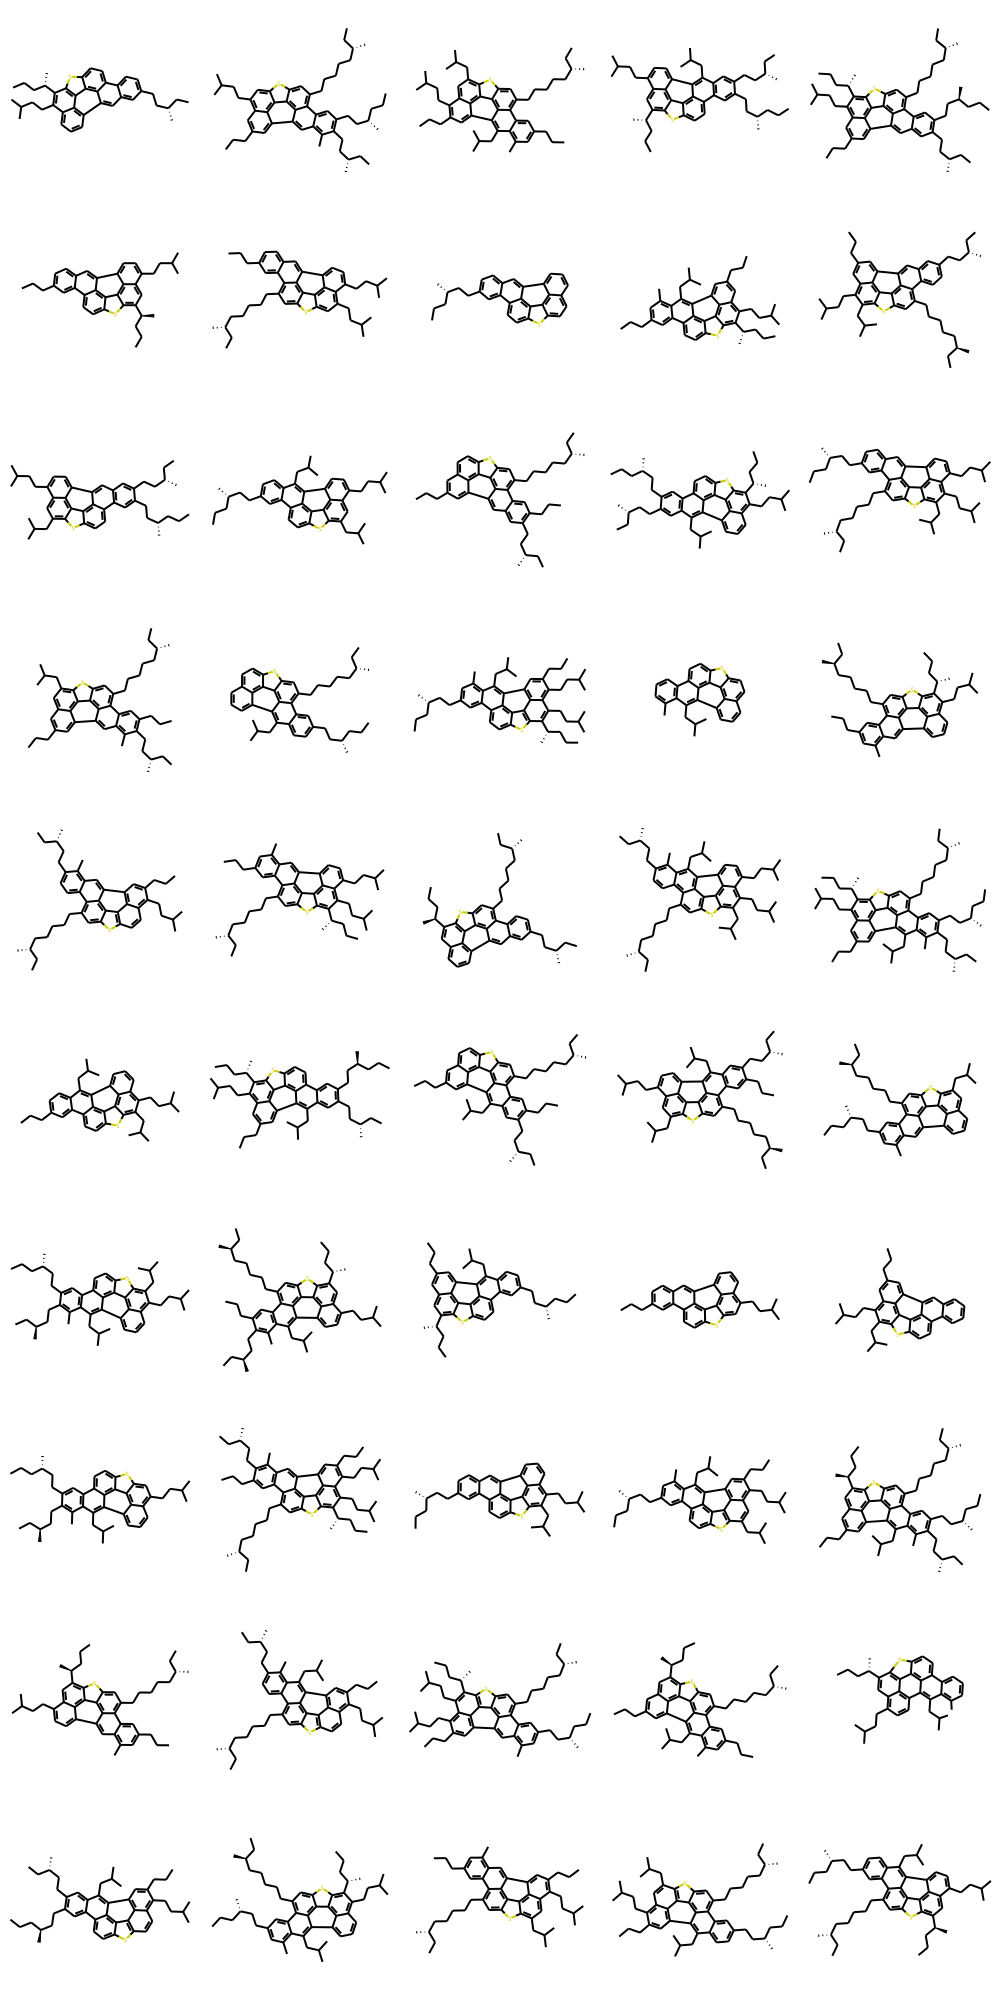

In [29]:
uniquemols=[]
for i in unique:
    uniquemols.append(Chem.MolFromSmiles(i))
print(len(uniquemols), "unique molecules generated")
Draw.MolsToGridImage(uniquemols[:100], molsPerRow=5)